In [24]:
import pandas as pd
import warnings
import requests
import io

# Disable all warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

# URL of the dataset
url = 'https://data.calgary.ca/api/views/qdxh-qngy/rows.csv?accessType=DOWNLOAD'

# Send a GET request to the URL
response = requests.get(url)

# Save the content to a CSV file
data = pd.read_csv(io.StringIO(response.text))

print(len(data))
data=data.drop_duplicates()
print(len(data))

118424
61875


In [25]:
# Create a new column with modified addresses
data["Modified Address"] = data["Program Address"].astype(str).apply(lambda x: x.split(",", 1)[1].strip() if "," in x else x)
data["Modified Address"] = data["Modified Address"].apply(lambda x: x.replace(" -", "") if " -" in x else x)
# Display the first few rows of the updated dataset
print(data[["Program Address", "Modified Address"]].head())

               Program Address             Modified Address
0  402 DISCOVERY RIDGE BLVD SW  402 DISCOVERY RIDGE BLVD SW
1          3715 - 67 STREET NE            3715 67 STREET NE
2               P.O. BOX 34067               P.O. BOX 34067
3         4013 STANLEY ROAD SW         4013 STANLEY ROAD SW
4      300, 340 MIDPARK WAY SE           340 MIDPARK WAY SE


In [26]:
#Normalizes the address line so that we can merge occupancy and neighbourhood geo data
import re
def normalize_address(address):
   
    if isinstance(address, str):
        abbreviations = {
            r'\bST\b': 'STREET',
            r'\bst\b': 'STREET',
            r'\bAVE\b': 'AVENUE',
            r'\bAVE.\b': 'AVENUE',
            r'\bBLVD\b': 'BOULEVARD',
            r'\bBV\b': 'BOULEVARD',
            r'\BLVD.\b': 'BOULEVARD',
            r'\bRD\b': 'ROAD',
            r'\bRD.\b': 'ROAD',
            r'\bLN\b': 'LANE',
            r'\bLN.\b': 'LANE',
            r'\bDR\b': 'DRIVE',
            r'\bDR.\b': 'DRIVE',
            r'\bPKWY\b': 'PARKWAY',
            r'\bPKWY.\b': 'PARKWAY',
            r'\bPA\b': 'PARK',
            r'\bPL\b': 'PLACE',
            r'\bPL.\b': 'PLACE',
            r'\bCT\b': 'COURT',
            r'\bCT.\b': 'COURT',
            r'\bCRT\b': 'COURT',
            r'\bW\b': 'WEST',
            r'\bE\b': 'EAST',
            r'\bN\b': 'NORTH',
            r'\bS\b': 'SOUTH',
            r'\bBathrust\b': 'BATHRUST',
            r'\bToronto\b': '',
            r'\b2nd\b': '',
            r'\bfloor\b': '',
            r'\bNORTHWEST\b': 'NW',
            r'\bNORTHEAST\b': 'NE',
            r'\bNSOUTHWEST\b': 'SW',
            r'\bSOUTHEAST\b': 'SE',
            r'\bAV\b': 'AVENUE',
            r'\bAVENE\b': 'AVENUE',
            r'\bWY\b': 'WAY',
            r'\bVW\b': 'VIEW',
            r'\bTR\b': 'TRAIL',
            r'\bCO\b': 'COURT',
            r'\bCRES\b': 'CRESCENT',
            r'\bCI\b': 'CIRCLE',
            r'\bCL\b': 'CLOSE',
            r'\bGR\b': 'GROVE',
            r'\bGA\b': 'GATE',
            r'\bRI\b': 'RISE',
            r'\bSQ\b': 'SQUARE',
            r'\bLD\b': 'LANDING',
            r'\bHE\b': 'HEATH',
            r'\bTC\b': 'TERRACE',
            r'\bLI\b': 'LINK',
            r'\bPZ\b': 'PLAZA',
            r'\bCM\b': 'COMMON',
            r'\bPR\b': 'PARADE',
            r'\bMR\b': 'MANOR',
            r'\bCR\b': 'CRESCENT',
            r'\bRO\b': 'ROW',
            r'\bGR\b': 'GREEN'
        }
        
 
        for abbr, full in abbreviations.items():
            address = re.sub(abbr, full, address)
 
        address = re.sub(r'[.,]','',address)
        address = address.strip()
 
    return address

In [27]:
import re
data['Normalized_ADDRESS']=data['Modified Address'].apply(lambda x: normalize_address(str(x)))
data
def clean_address(address):
    # Remove Calgary and anything that follows it (including space and postal code)
    address = re.sub(r'\s*CALGARY[A-Za-z]*\s*[A-Za-z]*\s*\w{6}', '', address)
    return address.strip()
data['Normalized_ADDRESS'] = data['Normalized_ADDRESS'].apply(lambda x: clean_address(str(x)))

In [28]:
import zipfile

# URL of the ZIP file
url = 'https://www150.statcan.gc.ca/n1/en/pub/46-26-0001/2021001/ODA_AB_v1.zip'

# Send a GET request to the URL
response = requests.get(url)

# Extract the ZIP file contents
with zipfile.ZipFile(io.BytesIO(response.content)) as the_zip:
    # Initialize an empty list to store chunks
    calgary_chunks = []
    # Check if the file ODA_AB_v1.csv is present in the ZIP archive
    if 'ODA_AB_v1.csv' in the_zip.namelist():
        # Open the CSV file and read it in chunks
        with the_zip.open('ODA_AB_v1.csv') as file:
            # Read the CSV file using a specific encoding and error handling
            for chunk in pd.read_csv(file, encoding='ISO-8859-1', on_bad_lines='skip', chunksize=10000):
                # Filter the chunk for entries related to the City of Calgary
                calgary_chunk = chunk[chunk['provider'] == 'City of Calgary']
                calgary_chunks.append(calgary_chunk)
    else:
        print("The file ODA_AB_v1.csv is not found in the ZIP archive.")

# Concatenate all filtered chunks
if calgary_chunks:
    calgary_df = pd.concat(calgary_chunks, ignore_index=True)

    # Check if the filtered DataFrame is not empty
    if not calgary_df.empty:
        # Display the first few rows of the filtered DataFrame
        print("Filtered DataFrame (City of Calgary):")
        calgary_df.head(5)
    else:
        print("No entries found for the City of Calgary.")
else:
    print("No data to concatenate. The chunks list is empty.")

# Now you can use 'calgary_df' for subsequent steps
# Example: Display the total number of entries related to Calgary
if 'calgary_df' in locals():
    print(f"Total entries related to Calgary: {len(calgary_df)}")

Filtered DataFrame (City of Calgary):
Total entries related to Calgary: 378779


In [29]:
# Use StringIO to read the CSV content into a DataFrame
calgary_df['Normalized_ADDRESS']=calgary_df['full_addr'].apply(lambda x: normalize_address(str(x)))
calgary_df

,latitude,longitude,source_id,id,group_id,street_no,street,str_name,str_type,str_dir,...,full_addr,city_pcs,str_name_pcs,str_type_pcs,str_dir_pcs,csduid,csdname,pruid,provider,Normalized_ADDRESS
0,51.08646,-114.19257,NaN,f38d3ac458343fc8f01e,6222014,7333,37 AV NW,37,AV,NW,...,7333 37 AV NW,CALGARY,37,AV,NW,4806016,Calgary,48,City of Calgary,7333 37 AVENUE NW
1,51.06721,-114.19440,NaN,a0268f3bb94295e1b8b3,6224232,7440,OLD BANFF COACH RD SW,OLD BANFF COACH,RD,SW,...,7440 OLD BANFF COACH RD SW,CALGARY,OLD BANFF COACH,RD,SW,4806016,Calgary,48,City of Calgary,7440 OLD BANFF COACH ROAD SW
2,51.07197,-114.09243,NaN,b693249a859c4dbc0a47,6029613,2211,13 ST NW,13,ST,NW,...,2211 13 ST NW,CALGARY,13,ST,NW,4806016,Calgary,48,City of Calgary,2211 13 STREET NW
3,51.09421,-114.19793,NaN,5f72fd92984825e10afc,6229388,7726,46 AV NW,46,AV,NW,...,7726 46 AV NW,CALGARY,46,AV,NW,4806016,Calgary,48,City of Calgary,7726 46 AVENUE NW
4,51.07220,-114.09257,NaN,620db6b0ef10661340f0,5953025,1403,22 AV NW,22,AV,NW,...,1403 22 AV NW,CALGARY,22,AV,NW,4806016,Calgary,48,City of Calgary,1403 22 AVENUE NW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378774,51.08739,-114.12310,NaN,d205c2864333562c67f3,6114458,3743,BROOKLYN CR NW,BROOKLYN,CR,NW,...,3743 BROOKLYN CR NW,CALGARY,BROOKLYN,CR,NW,4806016,Calgary,48,City of Calgary,3743 BROOKLYN CRESCENT NW
378775,51.02651,-113.98451,NaN,fbcd0c40010f606dd59b,6101703,3418,30A AV SE,30A,AV,SE,...,3418 30A AV SE,CALGARY,30A,AV,SE,4806016,Calgary,48,City of Calgary,3418 30A AVENUE SE
378776,51.11502,-113.91446,NaN,b3ca1fd3c05ea8714682,5928664,122,HOMESTEAD BV NE,HOMESTEAD,BV,NE,...,122 HOMESTEAD BV NE,CALGARY,HOMESTEAD,BLVD,NE,4806016,Calgary,48,City of Calgary,122 HOMESTEAD BOULEVARD NE
378777,51.03541,-113.98636,NaN,229a1d0ef6f616dcf1f0,6006114,1996,COTTONWOOD CR SE,COTTONWOOD,CR,SE,...,1996 COTTONWOOD CR SE,CALGARY,COTTONWOOD,CR,SE,4806016,Calgary,48,City of Calgary,1996 COTTONWOOD CRESCENT SE


In [30]:
merged_df = data.merge(calgary_df[['Normalized_ADDRESS', 'latitude', 'longitude']], on='Normalized_ADDRESS', how='left')
merged_df.isna().sum()

Program Name           3016
Type of Program        4330
Program Address           5
Program City              0
Postal Code              53
Phone Number          10496
Capacity                  0
Inspection Date        8422
Inspection Reason        81
Non Compliance        47366
Enforcement Action    47047
Remedy Date           51759
Unique ID             18649
Modified Address          0
Normalized_ADDRESS        0
latitude              16233
longitude             16233
dtype: int64

In [31]:
na_df = merged_df[merged_df['latitude'].isna()]
len(na_df['Normalized_ADDRESS'].unique())
null_df = merged_df[merged_df['latitude'].isna()]
null_df
notnull_df = merged_df[~merged_df['latitude'].isna()]
notnull_df


,Program Name,Type of Program,Program Address,Program City,Postal Code,Phone Number,Capacity,Inspection Date,Inspection Reason,Non Compliance,Enforcement Action,Remedy Date,Unique ID,Modified Address,Normalized_ADDRESS,latitude,longitude
0,DISCOVERY TOTS DAYHOME LTD,FAMILY DAY HOME,402 DISCOVERY RIDGE BLVD SW,CALGARY,T3H5T8,4.036189e+09,60,NaN,NaN,NaN,NaN,NaN,NaN,402 DISCOVERY RIDGE BLVD SW,402 DISCOVERY RIDGE BOULEVARD SW,51.01852,-114.22548
1,R&S QUALITY DAYHOME AGENCY,FAMILY DAY HOME,3715 - 67 STREET NE,CALGARY,T1Y5P3,4.038272e+09,30,NaN,NaN,NaN,NaN,NaN,NaN,3715 67 STREET NE,3715 67 STREET NE,51.08617,-113.93730
3,THE MANGROVE TREE DAYHOME AGENCY,FAMILY DAY HOME,4013 STANLEY ROAD SW,CALGARY,T2S2P5,4.036502e+09,30,NaN,NaN,NaN,NaN,NaN,NaN,4013 STANLEY ROAD SW,4013 STANLEY ROAD SW,51.01853,-114.06540
4,THE MANGROVE TREE DAYHOME AGENCY,FAMILY DAY HOME,4013 STANLEY ROAD SW,CALGARY,T2S2P5,4.036502e+09,30,NaN,NaN,NaN,NaN,NaN,NaN,4013 STANLEY ROAD SW,4013 STANLEY ROAD SW,51.01852,-114.06604
5,THE MANGROVE TREE DAYHOME AGENCY,FAMILY DAY HOME,4013 STANLEY ROAD SW,CALGARY,T2S2P5,4.036502e+09,30,NaN,NaN,NaN,NaN,NaN,NaN,4013 STANLEY ROAD SW,4013 STANLEY ROAD SW,51.01849,-114.06460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63002,DANA DAY CARE LTD.,FACILITY-BASED PROGRAM,3 ROSSDALE ROAD SWCALGARYABT3C2N9,CALGARY,T3C2N9,4.032422e+09,48,2020/06/03,INSPECTION,NaN,NaN,NaN,0917SMGW8000RGYE1678OW1236IU5976-DANA DAY CARE...,3 ROSSDALE ROAD SWCALGARYABT3C2N9,3 ROSSDALE ROAD SW,51.04627,-114.14879
63007,SEEDS OF S.P.I.C.E EARLY LEARNING CENTRE INC.,OUT OF SCHOOL CARE PROGRAM,"UNIT 9, 1330 15 AVE SW",CALGARY,T3C3N6,NaN,19,2016/03/03,RENEWAL LICENCE INSPECTION,NaN,NaN,NaN,E36F800D73EDA86E94041FF7B94F97EB-SEEDS OF S.P....,1330 15 AVE SW,1330 15 AVENUE SW,51.03956,-114.09383
63008,JUMP AND LEAP CHILDCARE,DAY CARE PROGRAM,"103, 1817 - 48 STREET SE",CALGARY,T2B1L9,5.873492e+09,27,2019/07/17,INSPECTION,25(1)(b) - Core Requirements - one in every 2 ...,ORDER TO REMEDY,2019/07/23,A57E4001EA43978E11081CF2F88D8F8F-JUMP AND LEAP...,1817 48 STREET SE,1817 48 STREET SE,51.03703,-113.96451
63009,BRIGHTPATH BERMUDA,DAY CARE PROGRAM,3 BERMUDA ROAD NW,CALGARY,T3K1G5,4.035160e+09,88,2016/09/28,INSPECTION,23(1)(a) - Administration Records- particulars...,ORDER TO REMEDY,NaN,BDD73EBCB147B727F2ADA126E11B1095-BRIGHTPATH BE...,3 BERMUDA ROAD NW,3 BERMUDA ROAD NW,51.12897,-114.08015


In [32]:
ll_df = notnull_df[['Program Name', 'Normalized_ADDRESS', 'latitude', 'longitude']].drop_duplicates()
ll_df

,Program Name,Normalized_ADDRESS,latitude,longitude
0,DISCOVERY TOTS DAYHOME LTD,402 DISCOVERY RIDGE BOULEVARD SW,51.01852,-114.22548
1,R&S QUALITY DAYHOME AGENCY,3715 67 STREET NE,51.08617,-113.93730
3,THE MANGROVE TREE DAYHOME AGENCY,4013 STANLEY ROAD SW,51.01853,-114.06540
4,THE MANGROVE TREE DAYHOME AGENCY,4013 STANLEY ROAD SW,51.01852,-114.06604
5,THE MANGROVE TREE DAYHOME AGENCY,4013 STANLEY ROAD SW,51.01849,-114.06460
...,...,...,...,...
57796,KIDS@ CHURCHILL PARK MOUNTVIEW OUT OF SCHOOL C...,2004 4 STREET NE,51.06971,-114.05230
59262,CALINOURS GROUP FAMILY CHILD CARE,115 ELGIN DRIVE SE,50.90638,-113.97182
59919,MANGROVE TREE ACADEMY INC.,7904 43 AVENUE NW,51.09128,-114.20013
61386,GLENDALE COMMUNITY PRESCHOOL,4943 8 AVENUE SW,51.04496,-114.15668


In [33]:
import pandas as pd

# Assuming you have merged_df and ll_df DataFrames already

# Iterate over rows in merged_df
for index, row in merged_df.iterrows():
    if pd.isnull(row['latitude']) or pd.isnull(row['longitude']):
        # Check if Program Name exists in ll_df
        program_name = row['Program Name']
        
        # Find corresponding latitude and longitude from ll_df
        matching_row = ll_df[ll_df['Program Name'] == program_name]
        
        if not matching_row.empty:
            # Assign latitude and longitude from ll_df to merged_df
            merged_df.at[index, 'latitude'] = matching_row['latitude'].values[0]
            merged_df.at[index, 'longitude'] = matching_row['longitude'].values[0]

# View updated merged_df
merged_df.head(5)


,Program Name,Type of Program,Program Address,Program City,Postal Code,Phone Number,Capacity,Inspection Date,Inspection Reason,Non Compliance,Enforcement Action,Remedy Date,Unique ID,Modified Address,Normalized_ADDRESS,latitude,longitude
0,DISCOVERY TOTS DAYHOME LTD,FAMILY DAY HOME,402 DISCOVERY RIDGE BLVD SW,CALGARY,T3H5T8,4.036189e+09,60,NaN,NaN,NaN,NaN,NaN,NaN,402 DISCOVERY RIDGE BLVD SW,402 DISCOVERY RIDGE BOULEVARD SW,51.01852,-114.22548
1,R&S QUALITY DAYHOME AGENCY,FAMILY DAY HOME,3715 - 67 STREET NE,CALGARY,T1Y5P3,4.038272e+09,30,NaN,NaN,NaN,NaN,NaN,NaN,3715 67 STREET NE,3715 67 STREET NE,51.08617,-113.93730
2,SONSHINE FAMILY DAY HOMES,FAMILY DAY HOME,P.O. BOX 34067,CALGARY,T3C3W2,4.037053e+09,270,NaN,NaN,NaN,NaN,NaN,NaN,P.O. BOX 34067,PO BOX 34067,NaN,NaN
3,THE MANGROVE TREE DAYHOME AGENCY,FAMILY DAY HOME,4013 STANLEY ROAD SW,CALGARY,T2S2P5,4.036502e+09,30,NaN,NaN,NaN,NaN,NaN,NaN,4013 STANLEY ROAD SW,4013 STANLEY ROAD SW,51.01853,-114.06540
4,THE MANGROVE TREE DAYHOME AGENCY,FAMILY DAY HOME,4013 STANLEY ROAD SW,CALGARY,T2S2P5,4.036502e+09,30,NaN,NaN,NaN,NaN,NaN,NaN,4013 STANLEY ROAD SW,4013 STANLEY ROAD SW,51.01852,-114.06604


In [34]:
merged_df.isna().sum()

Program Name           3016
Type of Program        4330
Program Address           5
Program City              0
Postal Code              53
Phone Number          10496
Capacity                  0
Inspection Date        8422
Inspection Reason        81
Non Compliance        47366
Enforcement Action    47047
Remedy Date           51759
Unique ID             18649
Modified Address          0
Normalized_ADDRESS        0
latitude              10635
longitude             10635
dtype: int64

In [35]:
merged_df=merged_df.drop(columns= ['Phone Number', 'Program Address', 'Modified Address', 'Unique ID'])
merged_df = merged_df.rename(columns={'Normalized_ADDRESS' : 'Program_Address'})

In [36]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

 
# Ensure 'Type of Program' exists
if "Type of Program" not in merged_df.columns:
    raise ValueError("Column 'Type of Program' not found in dataset")
 
# Separate rows with known & unknown 'Type of Program'
df_known = merged_df.dropna(subset=["Type of Program"])  # Rows with values
df_missing = merged_df[merged_df["Type of Program"].isnull()]  # Rows with missing values
 
# Encode 'Type of Program' using LabelEncoder
target_encoder = LabelEncoder()
df_known["Type of Program"] = target_encoder.fit_transform(df_known["Type of Program"])
 
# Select features (drop ID columns & target variable)
features = df_known.drop(columns=["Type of Program", "Unique ID", "Program Address"], errors="ignore")
target = df_known["Type of Program"]
 
# Encode categorical variables in features
categorical_columns = features.select_dtypes(include=['object']).columns
for col in categorical_columns:
    le = LabelEncoder()
    features[col] = le.fit_transform(features[col].astype(str))
 
# Train a model
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
 
# Prepare df_missing for prediction
df_missing_features = df_missing[features.columns].copy()
 
# Encode categorical columns in df_missing
for col in categorical_columns:
    if col in df_missing_features.columns:
        df_missing_features[col] = df_missing_features[col].astype(str)
        df_missing_features[col] = df_missing_features[col].apply(
            lambda x: le.transform([x])[0] if x in le.classes_ else -1
        )
 
# Predict missing 'Type of Program' values
if not df_missing.empty:
    df_missing["Type of Program"] = rf_classifier.predict(df_missing_features)
 
    # Decode back to original labels
    df_missing["Type of Program"] = target_encoder.inverse_transform(df_missing["Type of Program"].astype(int))
 
    # Merge back into original dataset
    merged_df.loc[df_missing.index, "Type of Program"] = df_missing["Type of Program"]
 
# Check remaining missing values
print(f"Remaining missing values in 'Type of Program': {merged_df['Type of Program'].isnull().sum()}")

Remaining missing values in 'Type of Program': 0


In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Use 'weighted' for imbalanced classes
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.9126
Precision: 0.9126
Recall: 0.9126
F1 Score: 0.9126


In [38]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

 
# Ensure 'Type of Program' exists
if "Program Name" not in merged_df.columns:
    raise ValueError("Column 'Program Name' not found in dataset")
 
# Separate rows with known & unknown 'Type of Program'
df_known = merged_df.dropna(subset=["Program Name"])  # Rows with values
df_missing = merged_df[merged_df["Program Name"].isnull()]  # Rows with missing values
 
# Encode 'Type of Program' using LabelEncoder
target_encoder = LabelEncoder()
df_known["Program Name"] = target_encoder.fit_transform(df_known["Program Name"])
 
# Select features (drop ID columns & target variable)
features = df_known.drop(columns=["Program Name", "Program_Address"], errors="ignore")
target = df_known["Program Name"]
 
# Encode categorical variables in features
categorical_columns = features.select_dtypes(include=['object']).columns
for col in categorical_columns:
    le = LabelEncoder()
    features[col] = le.fit_transform(features[col].astype(str))
 
# Train a model
X_train, X_testi, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
 
# Prepare df_missing for prediction
df_missing_features = df_missing[features.columns].copy()
 
# Encode categorical columns in df_missing
for col in categorical_columns:
    if col in df_missing_features.columns:
        df_missing_features[col] = df_missing_features[col].astype(str)
        df_missing_features[col] = df_missing_features[col].apply(
            lambda x: le.transform([x])[0] if x in le.classes_ else -1
        )
 
# Predict missing 'Type of Program' values
if not df_missing.empty:
    df_missing["Program Name"] = rf_classifier.predict(df_missing_features)
 
    # Decode back to original labels
    df_missing["Program Name"] = target_encoder.inverse_transform(df_missing["Program Name"].astype(int))
 
    # Merge back into original dataset
    merged_df.loc[df_missing.index, "Program Name"] = df_missing["Program Name"]
 
# Check remaining missing values
print(f"Remaining missing values in 'Program Name': {merged_df['Program Name'].isnull().sum()}")


Remaining missing values in 'Program Name': 0


In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test set
y_pred = rf_classifier.predict(X_testi)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')  # Use 'weighted' for imbalanced classes
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Accuracy: 0.9517
Precision: 0.9549
Recall: 0.9517
F1 Score: 0.9506


In [40]:
merged_df=merged_df.drop_duplicates()
filtered_df = merged_df.dropna(subset=['latitude', 'longitude'])
# Display the result
print(len(filtered_df))
filtered_df=filtered_df.drop_duplicates()
len(merged_df['Program Name'].unique())
print(len(filtered_df['Program Name'].unique()))

42297
1010


In [41]:
filtered_df = filtered_df[~((filtered_df['Inspection Reason'].notnull()) & (filtered_df['Inspection Date'].isnull()))]

# Drop duplicates and keep only the first occurrence based on relevant columns
filtered_df = filtered_df.drop_duplicates(subset=[
    'Program Name', 'Type of Program', 'Program City', 'Postal Code', 'Program_Address',
    'Capacity', 'Inspection Date', 'Inspection Reason', 'Non Compliance', 'Enforcement Action', 'Remedy Date'
])

# Display the result
filtered_df.head(5)
filtered_df.drop_duplicates

# Check the number of rows removed
rows_removed = len(merged_df) - len(filtered_df)

print(f"Number of rows removed: {rows_removed}")


Number of rows removed: 16079


In [42]:
filtered_df_unique = filtered_df.groupby([
    'Postal Code'  
]).agg({
    'latitude': 'first',
    'longitude': 'first'  
}).reset_index()

filtered_df_unique=filtered_df_unique.drop_duplicates()

# Merge the DataFrames to map latitude and longitude based on Postal Code

filtered_df = filtered_df.dropna(subset=['latitude', 'longitude'])
filtered_df = filtered_df.merge(filtered_df_unique, on='Postal Code', how='inner', suffixes=('', '_y'))

# Replace the latitude and longitude values with the new ones
filtered_df['latitude'] = filtered_df['latitude_y']
filtered_df['longitude'] = filtered_df['longitude_y']

# Drop the temporary columns used for mapping
filtered_df = filtered_df.drop(columns=['latitude_y', 'longitude_y'])

# Display the result
filtered_df.head(5)

# Check the number of rows and unique Program Names in filtered_df
print(f"Number of rows in filtered_df: {len(filtered_df)}")
print(f"Number of unique Program Names in filtered_df: {len(filtered_df['Program Name'].unique())}")


Number of rows in filtered_df: 35078
Number of unique Program Names in filtered_df: 1004


In [43]:
filtered_df.drop_duplicates()
len(filtered_df)
filtered_df.to_csv("final_output.csv")

(0.0, 346.3333333333333)

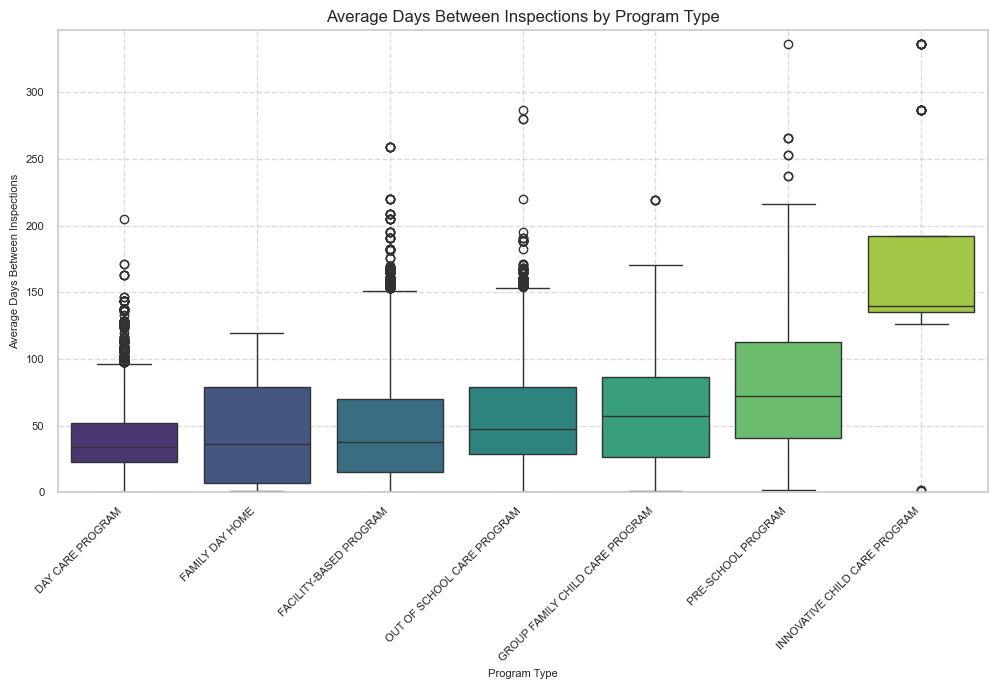

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the dataset
df = filtered_df

# Convert 'Inspection Date' to datetime
df['Inspection Date'] = pd.to_datetime(df['Inspection Date'], errors='coerce')

# Drop rows where 'Inspection Date' is NaN
df_cleaned = df.dropna(subset=['Inspection Date'])

# Extract year from inspection date
df_cleaned['Year'] = df_cleaned['Inspection Date'].dt.year

# Ensure 'Year' is also present in df before merging
df['Year'] = df['Inspection Date'].dt.year

# Count inspections per program per year
inspection_counts_yearly = df_cleaned.groupby(["Program Name", "Year"]).size().reset_index(name="Annual Inspection Frequency")

# Merge annual inspection frequency back to the main dataset
df = df.merge(inspection_counts_yearly, on=["Program Name", "Year"], how="left")
df["Annual Inspection Frequency"] = df["Annual Inspection Frequency"].fillna(0)

# Mapping encoded values back to program type
df["Program Type"] = df["Type of Program"].astype("category")

# Calculate inspection frequency based on date
df_sorted = df_cleaned.sort_values(by=["Program Name", "Inspection Date"])
df_sorted['Days Between Inspections'] = df_sorted.groupby("Program Name")['Inspection Date'].diff().dt.days
# Calculate average inspection interval per program
date_inspection_frequency = df_sorted.groupby("Program Name")['Days Between Inspections'].mean().reset_index()
date_inspection_frequency.rename(columns={'Days Between Inspections': 'Avg Days Between Inspections'}, inplace=True)

# Merge back with main dataset
df = df.merge(date_inspection_frequency, on="Program Name", how="left")
df=df[['Program Name','Program Type','Avg Days Between Inspections']]
df.drop_duplicates
df.to_csv("testtest.csv")

# Sort by program type for better readability
sorted_types = df.groupby("Program Type")["Avg Days Between Inspections"].mean().sort_values().index


# Set theme for better visuals
sns.set_theme(style="whitegrid", palette="pastel")


# Box plot with adjusted x-axis scale
plt.figure(figsize=(12, 6))  # Increase figure size for better readability
sns.boxplot(x='Program Type', y='Avg Days Between Inspections', data=df, order=sorted_types, palette="viridis")
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("Program Type", fontsize=8)
plt.ylabel("Average Days Between Inspections", fontsize=8)
plt.title("Average Days Between Inspections by Program Type", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Set y-axis scale from 0 to a suitable maximum value with some padding
max_value = df['Avg Days Between Inspections'].max()
plt.ylim(0, max_value + 10)


In [45]:
filtered_df = merged_df.dropna(subset=['latitude', 'longitude'])
filtered_df=filtered_df.drop_duplicates()

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Assuming df is your starting DataFrame

filtered_df=pd.read_csv("final_output.csv")

df = filtered_df

# Create a binary target column for non-compliance indication
df['Non_Compliance_Indicator'] = df.apply(lambda x: 1 if pd.notnull(x['Non Compliance']) and x['Non Compliance'].strip() != '' else 0, axis=1)

# Handle missing values (example: dropping rows with missing values)
df.dropna(subset=['Capacity', 'Type of Program', 'Postal Code'], inplace=True)

# Select the relevant columns for modeling
selected_features = ['Capacity', 'Non_Compliance_Indicator', 'Type of Program', 'Postal Code']
df_selected = df[selected_features]

# Encode categorical variables using one-hot encoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_features = encoder.fit_transform(df_selected[['Type of Program', 'Postal Code']])

# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['Type of Program', 'Postal Code']))

# Concatenate encoded features with the original dataset (excluding the original categorical columns)
df_encoded = pd.concat([df_selected[['Capacity', 'Non_Compliance_Indicator']].reset_index(drop=True), encoded_df.reset_index(drop=True)], axis=1)

# Split the data into training and testing sets
X = df_encoded.drop(columns=['Non_Compliance_Indicator'])
y = df_encoded['Non_Compliance_Indicator']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the shapes of the training and testing sets
print(f'Training set shape: {X_train.shape}, {y_train.shape}')
print(f'Testing set shape: {X_test.shape}, {y_test.shape}')



Training set shape: (28062, 713), (28062,)
Testing set shape: (7016, 713), (7016,)


In [5]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the new class distribution after resampling
class_distribution_resampled = pd.Series(y_train_resampled).value_counts()
print("Class Distribution in Resampled Training Data:\n", class_distribution_resampled)




from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Train Logistic Regression model on resampled data
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_resampled, y_train_resampled)
y_pred_lr_resampled = lr_model.predict(X_test)

# Evaluate the model
conf_matrix_resampled = confusion_matrix(y_test, y_pred_lr_resampled)
class_report_resampled = classification_report(y_test, y_pred_lr_resampled)

print("Confusion Matrix (Resampled Data):\n", conf_matrix_resampled)
print("Classification Report (Resampled Data):\n", class_report_resampled)

Class Distribution in Resampled Training Data:
 Non_Compliance_Indicator
0    20649
1    20649
Name: count, dtype: int64
Confusion Matrix (Resampled Data):
 [[3254 1921]
 [ 579 1262]]
Classification Report (Resampled Data):
               precision    recall  f1-score   support

           0       0.85      0.63      0.72      5175
           1       0.40      0.69      0.50      1841

    accuracy                           0.64      7016
   macro avg       0.62      0.66      0.61      7016
weighted avg       0.73      0.64      0.66      7016



C:\Users\Venkateshwaran\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Non Compliance Data Distribution Before SMOTE:
 Non_Compliance_Indicator
0    20649
1     7413
Name: count, dtype: int64
Non Compliance Data Distribution After SMOTE:
 Non_Compliance_Indicator
0    20649
1    20649
Name: count, dtype: int64


C:\Users\Venkateshwaran\AppData\Local\Temp\ipykernel_37156\3941744668.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution_original.index, y=class_distribution_original.values, ax=axes[0], palette="Blues")
C:\Users\Venkateshwaran\AppData\Local\Temp\ipykernel_37156\3941744668.py:29: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["Class 0", "Class 1"])
C:\Users\Venkateshwaran\AppData\Local\Temp\ipykernel_37156\3941744668.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution_resampled.index, y=class_distribution_resampled.values, ax=axes[1], pale

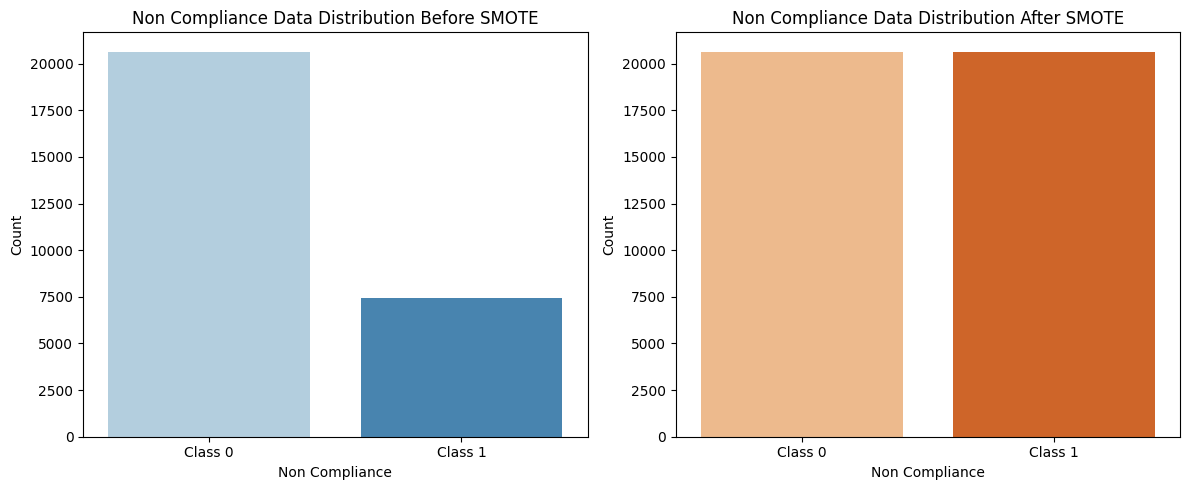

Confusion Matrix (Resampled Data):
 [[3254 1921]
 [ 579 1262]]
Classification Report (Resampled Data):
               precision    recall  f1-score   support

           0       0.85      0.63      0.72      5175
           1       0.40      0.69      0.50      1841

    accuracy                           0.64      7016
   macro avg       0.62      0.66      0.61      7016
weighted avg       0.73      0.64      0.66      7016



C:\Users\Venkateshwaran\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Check the original class distribution before SMOTE
class_distribution_original = pd.Series(y_train).value_counts()
print("Non Compliance Data Distribution Before SMOTE:\n", class_distribution_original)

# Apply SMOTE to oversample the minority class
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Check the new class distribution after SMOTE
class_distribution_resampled = pd.Series(y_train_resampled).value_counts()
print("Non Compliance Data Distribution After SMOTE:\n", class_distribution_resampled)

# Plot class distribution before and after SMOTE
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
sns.barplot(x=class_distribution_original.index, y=class_distribution_original.values, ax=axes[0], palette="Blues")
axes[0].set_title("Non Compliance Data Distribution Before SMOTE")
axes[0].set_xlabel("Non Compliance")
axes[0].set_ylabel("Count")
axes[0].set_xticklabels(["Class 0", "Class 1"])

# After SMOTE
sns.barplot(x=class_distribution_resampled.index, y=class_distribution_resampled.values, ax=axes[1], palette="Oranges")
axes[1].set_title("Non Compliance Data Distribution After SMOTE")
axes[1].set_xlabel("Non Compliance")
axes[1].set_ylabel("Count")
axes[1].set_xticklabels(["Class 0", "Class 1"])

plt.tight_layout()
plt.show()

# Train Logistic Regression model on resampled data
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_resampled, y_train_resampled)
y_pred_lr_resampled = lr_model.predict(X_test)

# Evaluate the model
conf_matrix_resampled = confusion_matrix(y_test, y_pred_lr_resampled)
class_report_resampled = classification_report(y_test, y_pred_lr_resampled)

print("Confusion Matrix (Resampled Data):\n", conf_matrix_resampled)
print("Classification Report (Resampled Data):\n", class_report_resampled)


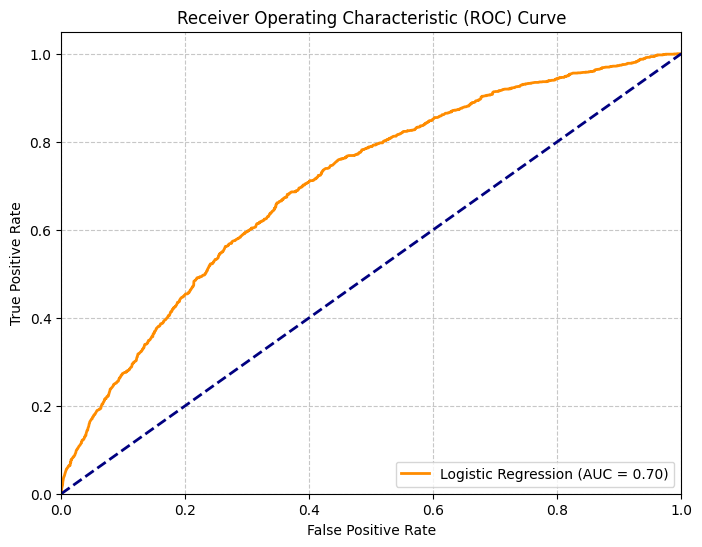

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score

y_pred_prob_resampled = lr_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_resampled)
roc_auc = roc_auc_score(y_test, y_pred_prob_resampled)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

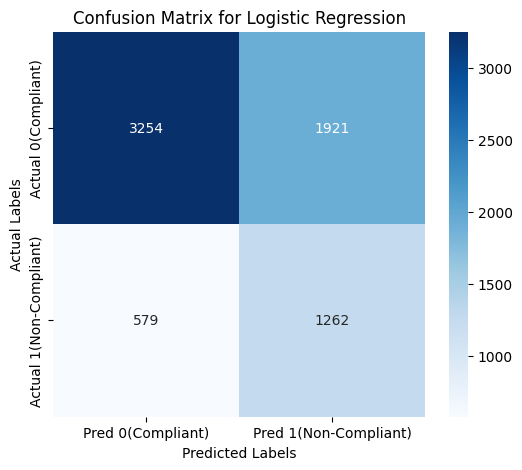

In [9]:
# Compute confusion matrix
conf_matrix_resampled = confusion_matrix(y_test, y_pred_lr_resampled)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix_resampled, annot=True, fmt="d", cmap="Blues", xticklabels=["Pred 0(Compliant)", "Pred 1(Non-Compliant)"], yticklabels=["Actual 0(Compliant)", "Actual 1(Non-Compliant)"])
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix for Logistic Regression")
plt.show()

In [48]:
# Create new data for prediction scenarios
scenario_1 = pd.DataFrame({
    'Capacity': [10],
    'Type of Program': ['GROUP FAMILY CHILD PROGRAM'],
    'Postal Code': ['T2M3T4'] 
    # Replace with actual program type from your data
})

scenario_2 = pd.DataFrame({
    'Capacity': [6050],
    'Type of Program': ['INNOVATIVE CHILD CARE PROGRAM'],
      'Postal Code': ['T2M3T4']  # Replace with actual program type from your data
   
})

# Encode the Type of Program using the same encoder
encoded_scenario_1 = encoder.transform(scenario_1[['Type of Program','Postal Code']])
encoded_scenario_1_df = pd.DataFrame(encoded_scenario_1, columns=encoder.get_feature_names_out(['Type of Program','Postal Code']))

encoded_scenario_2 = encoder.transform(scenario_2[['Type of Program','Postal Code']])

encoded_scenario_2_df = pd.DataFrame(encoded_scenario_2, columns=encoder.get_feature_names_out(['Type of Program','Postal Code']))

# Concatenate encoded features with the Capacity for each scenario
scenario_1_encoded = pd.concat([scenario_1[['Capacity']].reset_index(drop=True), encoded_scenario_1_df.reset_index(drop=True)], axis=1)
scenario_2_encoded = pd.concat([scenario_2[['Capacity']].reset_index(drop=True), encoded_scenario_2_df.reset_index(drop=True)], axis=1)

# Make predictions
prediction_1 = lr_model.predict(scenario_1_encoded)
prediction_2 = lr_model.predict(scenario_2_encoded)

print("Prediction for Scenario 1 (Non-Compliance Likelihood):", prediction_1)
print("Prediction for Scenario 2 (Non-Compliance Likelihood):", prediction_2)

Prediction for Scenario 1 (Non-Compliance Likelihood): [0]
Prediction for Scenario 2 (Non-Compliance Likelihood): [1]


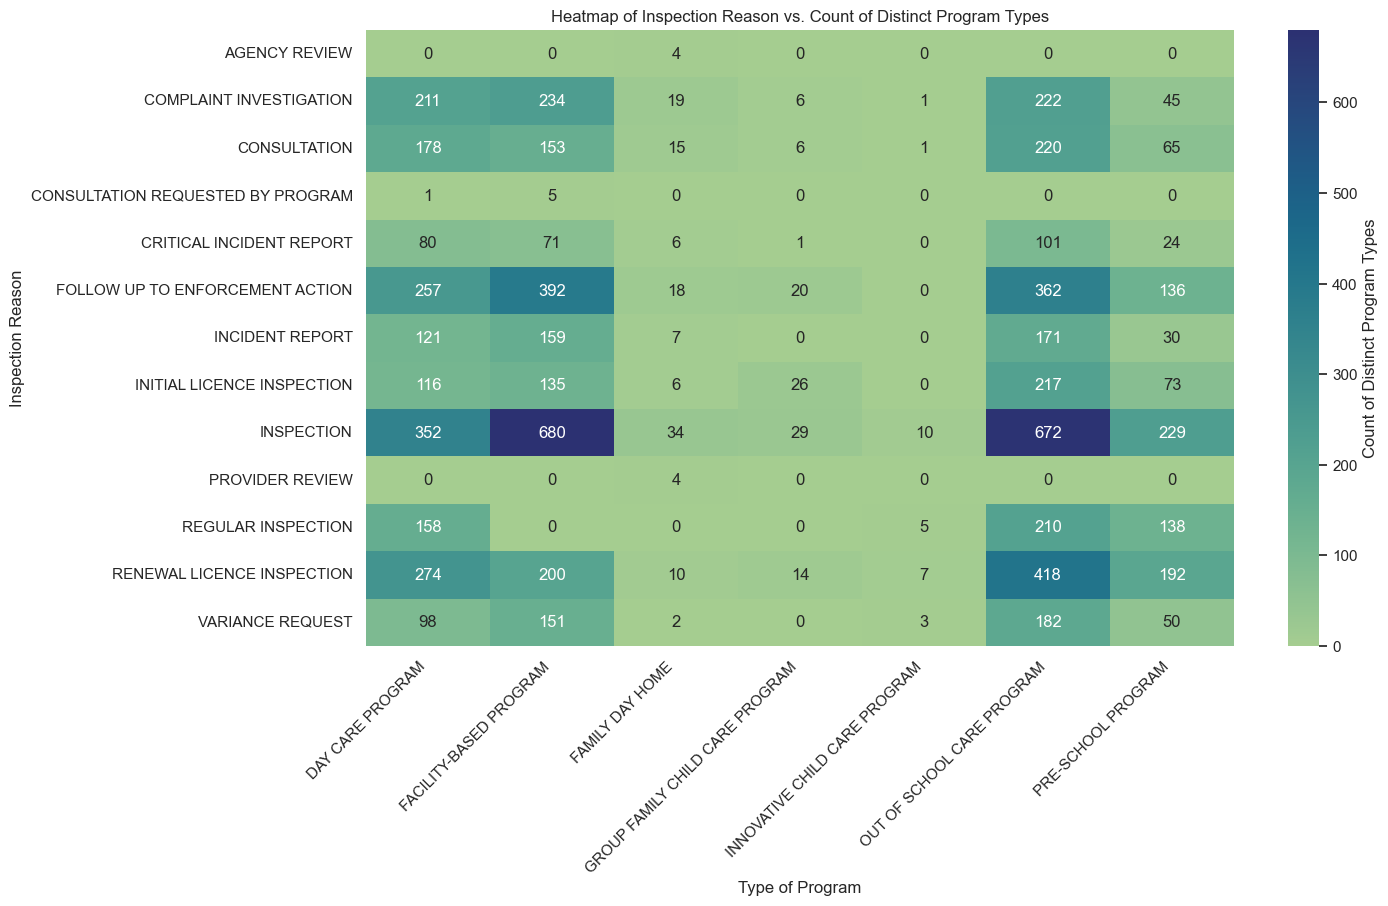

In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset (replace filtered_df with your actual DataFrame variable)
df = filtered_df

# Convert "Inspection Reason" to upper case
df['Inspection Reason'] = df['Inspection Reason'].str.upper()

# Count distinct inspection reasons per program type
heatmap_data = df.groupby(['Inspection Reason', 'Type of Program'])['Program Name'].nunique().reset_index()

# Pivot the data for heatmap visualization
heatmap_data = heatmap_data.pivot(index='Inspection Reason', columns='Type of Program', values='Program Name').fillna(0)

# Round off to whole numbers
heatmap_data = heatmap_data.round(0)

# Set up the heatmap
plt.figure(figsize=(14, 8))
ax = sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='crest')

# Labels and title
plt.xlabel('Type of Program')
plt.ylabel('Inspection Reason')
plt.title('Heatmap of Inspection Reason vs. Count of Distinct Program Types')
plt.xticks(rotation=45, ha='right')

# Show legend for program types
colorbar = ax.collections[0].colorbar
colorbar.set_label('Count of Distinct Program Types')

# Show the heatmap
plt.show()


Compliant communities saved as compliant_communities.csv


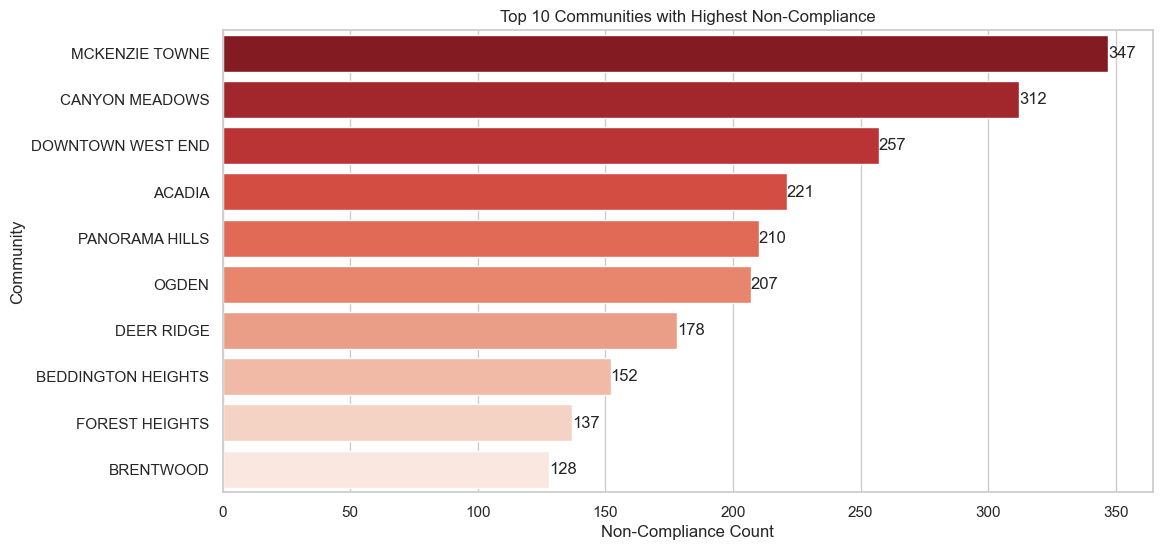

Heatmap saved as inspection_heatmap.html


In [56]:
import pandas as pd
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import BallTree
import numpy as np

# Load inspection and community data
inspection_data = pd.read_csv("final_output.csv")
community_data = pd.read_csv("Community_Points_20250210.csv")

# Convert lat/lon to radians for spatial matching
community_data[['latitude', 'longitude']] = np.radians(community_data[['latitude', 'longitude']])
inspection_data[['latitude', 'longitude']] = np.radians(inspection_data[['latitude', 'longitude']])

# Build spatial index
tree = BallTree(community_data[['latitude', 'longitude']], metric='haversine')

# Find the closest community for each inspection entry
distances, indices = tree.query(inspection_data[['latitude', 'longitude']], k=1)

# Assign community names to inspection dataset
inspection_data['Nearest_Community'] = community_data.iloc[indices.flatten()]['NAME'].values

# Convert lat/lon back to degrees
community_data[['latitude', 'longitude']] = np.degrees(community_data[['latitude', 'longitude']])
inspection_data[['latitude', 'longitude']] = np.degrees(inspection_data[['latitude', 'longitude']])

# Group by community and count non-compliance cases
inspection_data_grouped = inspection_data[inspection_data["Non Compliance"].notnull()].groupby("Nearest_Community")["Non Compliance"].count().reset_index()
inspection_data_grouped.columns = ['Nearest_Community', 'Non_Compliance_Count']

# Identify communities with inspections (either compliant or non-compliant)
inspected_communities = set(inspection_data['Nearest_Community'].unique())

# Identify communities without non-compliance among inspected ones
compliant_communities = inspected_communities - set(inspection_data_grouped['Nearest_Community'])
compliant_communities_df = pd.DataFrame({"Nearest_Community": list(compliant_communities)})

# Save the list of compliant communities
compliant_communities_df.to_csv("compliant_communities.csv", index=False)
print("Compliant communities saved as compliant_communities.csv")

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=inspection_data_grouped.sort_values("Non_Compliance_Count", ascending=False).head(10),
    x="Non_Compliance_Count", y="Nearest_Community", palette="Reds_r"
)

# Add values on top of each bar
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel("Non-Compliance Count")
plt.ylabel("Community")
plt.title("Top 10 Communities with Highest Non-Compliance")
plt.show()


# Heatmap Visualization
m = folium.Map(location=[51.0447, -114.0719], zoom_start=11)

# Add markers for non-compliant communities
for _, row in inspection_data_grouped.iterrows():
    community = row["Nearest_Community"]
    count = row["Non_Compliance_Count"]
    coords = community_data.loc[community_data['NAME'] == community, ['latitude', 'longitude']]
    if not coords.empty:
        folium.CircleMarker(
            location=[coords.iloc[0]['latitude'], coords.iloc[0]['longitude']],
            radius=count / 15,
            color="red",
            fill=True,
            fill_color="red",
            fill_opacity=0.6,
            popup=f"{community}: {count} non-compliance cases"
        ).add_to(m)

# Add markers for fully compliant communities among inspected ones
for _, row in community_data.iterrows():
    community = row["NAME"]
    if community in compliant_communities:
        folium.CircleMarker(
            location=[row['latitude'], row['longitude']],
            radius=5,
            color="green",
            fill=True,
            fill_color="green",
            fill_opacity=0.6,
            popup=f"{community}: 0 non-compliance cases"
        ).add_to(m)

# Add a legend to the map
legend_html = '''
<div style="
    position: fixed; 
    bottom: 50px; 
    left: 50px; 
    width: 250px; 
    height: 120px; 
    background-color: white; 
    border: 2px solid grey; 
    border-radius: 5px; 
    box-shadow: 2px 2px 5px rgba(0,0,0,0.3); 
    z-index: 1000; 
    font-size: 14px;
    ">
    <div style="margin: 10px;">
        <h4 style="margin: 0 0 10px 0; font-size: 16px;">Legend</h4>
        <i class="fa fa-circle" style="color:red"></i> Non-Compliant Community<br>
        <i class="fa fa-circle" style="color:green"></i> Fully Compliant Community
    </div>
</div>
'''
m.get_root().html.add_child(folium.Element(legend_html))


m.save("inspection_heatmap.html")  # Save heatmap as an interactive HTML file
print("Heatmap saved as inspection_heatmap.html")

m


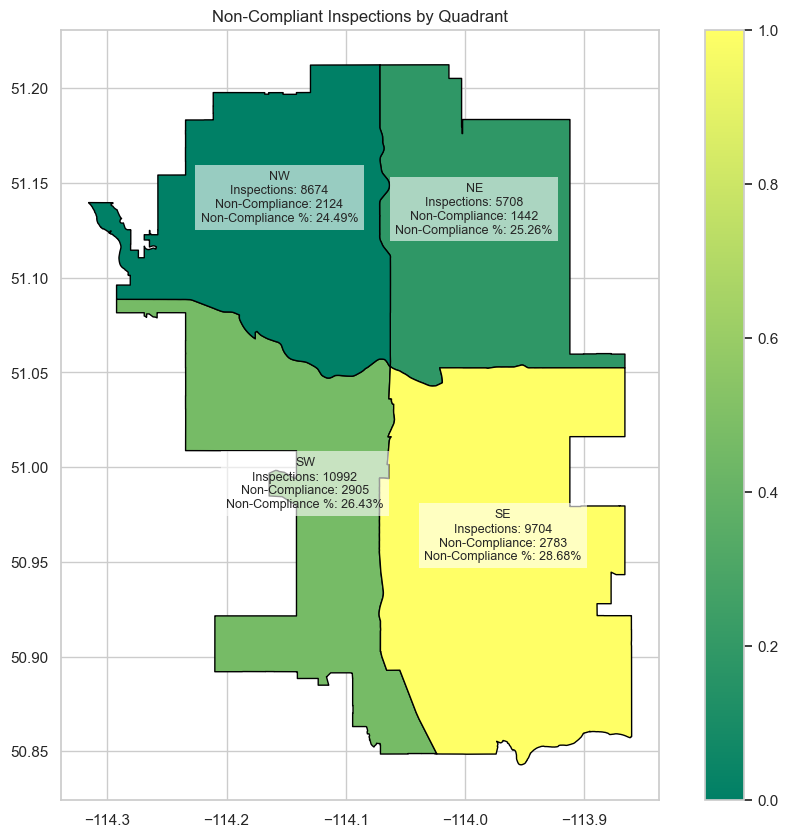

In [51]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.wkt import loads
from shapely.geometry import Point

# Load datasets
inspections_df = pd.read_csv("final_output.csv")
quadrants_df = pd.read_csv("City_Quadrants_20250210.csv")

# Convert MULTIPOLYGON from WKT format to geometry
quadrants_df["geometry"] = quadrants_df["MULTIPOLYGON"].apply(lambda x: loads(x) if isinstance(x, str) else None)
quadrants_gdf = gpd.GeoDataFrame(quadrants_df, geometry="geometry", crs="EPSG:4326")

# Process inspection data
inspections_df["Non Compliance Indicator"] = inspections_df["Inspection Date"].notnull().astype(int)
inspections_df.loc[inspections_df["Non Compliance"].notnull(), "Non Compliance Indicator"] = "Y"

# Convert inspections to GeoDataFrame
inspections_df = inspections_df.dropna(subset=["latitude", "longitude"])  # Remove rows without coordinates
inspections_gdf = gpd.GeoDataFrame(inspections_df, 
                                   geometry=[Point(xy) for xy in zip(inspections_df.longitude, inspections_df.latitude)],
                                   crs="EPSG:4326")

# Spatial join to map inspections to quadrants
inspections_gdf = gpd.sjoin(inspections_gdf, quadrants_gdf, how="left", predicate="within")

# Count total inspections per quadrant
total_inspections = inspections_gdf["QUADRANT"].value_counts()

# Count non-compliant cases per quadrant
non_compliant_counts = inspections_gdf[inspections_gdf["Non Compliance Indicator"] == "Y"]["QUADRANT"].value_counts()

# Merge counts into quadrants GeoDataFrame
quadrants_gdf["Total Inspections"] = quadrants_gdf["QUADRANT"].map(total_inspections).fillna(0)
quadrants_gdf["Non Compliance Count"] = quadrants_gdf["QUADRANT"].map(non_compliant_counts).fillna(0)

# Calculate non-compliance percentage
quadrants_gdf["Non Compliance %"] = quadrants_gdf["Non Compliance Count"] / quadrants_gdf["Total Inspections"]
quadrants_gdf["Non Compliance %"].fillna(0, inplace=True)

# Normalize for coloring
df_min = quadrants_gdf["Non Compliance %"].min()
df_max = quadrants_gdf["Non Compliance %"].max()
quadrants_gdf["color_intensity"] = (quadrants_gdf["Non Compliance %"] - df_min) / (df_max - df_min)

# Plot the map with quadrant colors (Green -> Orange based on Non Compliance %)
fig, ax = plt.subplots(figsize=(12, 10))
quadrants_gdf.plot(ax=ax, column="color_intensity", cmap="summer", edgecolor='black', legend=True)

# Add quadrant labels with counts
for idx, row in quadrants_gdf.iterrows():
    if row.geometry.centroid.x and row.geometry.centroid.y:
        plt.text(row.geometry.centroid.x, row.geometry.centroid.y, 
                 f"{row['QUADRANT']}\nInspections: {int(row['Total Inspections'])}\nNon-Compliance: {int(row['Non Compliance Count'])}\nNon-Compliance %: {row['Non Compliance %']:.2%}",
                 ha='center', fontsize=9, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

plt.title("Non-Compliant Inspections by Quadrant")
plt.show()




     Nearest_Community  Total_Inspections  Non_Compliance_Count
105  LOWER MOUNT ROYAL                 60                   0.0
149        ROCKY RIDGE                 46                   0.0
38        CHINOOK PARK                 27                   0.0
135            PEGASUS                 17                   0.0
76            FRANKLIN                 16                   0.0
86       HARVEST HILLS                 14                   0.0
204        WOLF WILLOW                 12                   0.0
147        RIDEAU PARK                  8                   0.0
170       SKYLINE EAST                  5                   0.0
179       SPRUCE CLIFF                  3                   0.0


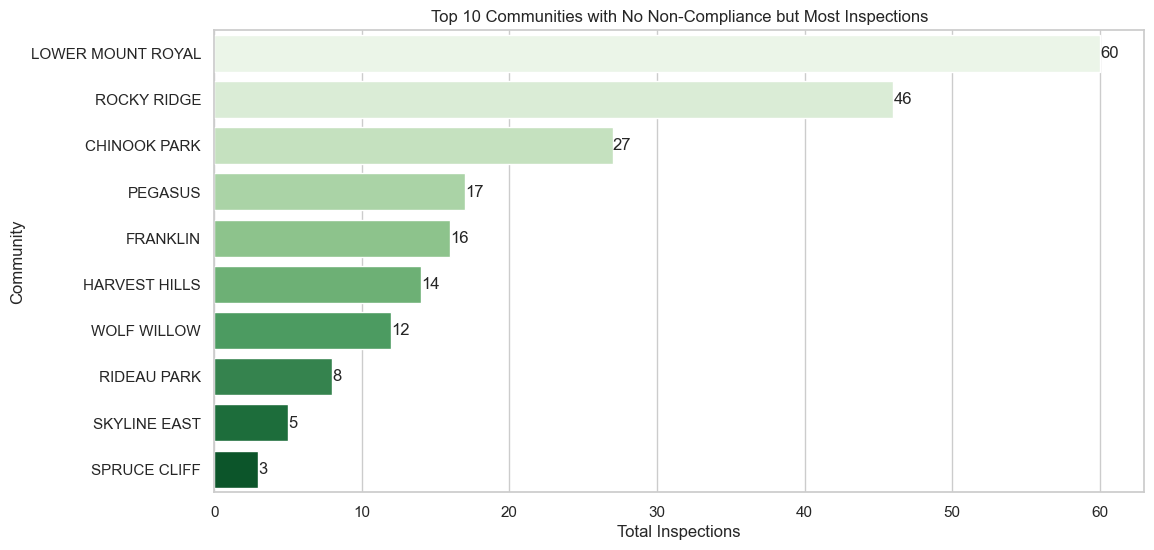

Heatmap saved as compliant_communities_heatmap.html


In [52]:
import pandas as pd
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import BallTree
import numpy as np

# Load inspection and community data
inspection_data = pd.read_csv("final_output.csv")
community_data = pd.read_csv("Community_Points_20250210.csv")

# Convert lat/lon to radians for spatial matching
community_data[['latitude', 'longitude']] = np.radians(community_data[['latitude', 'longitude']])
inspection_data[['latitude', 'longitude']] = np.radians(inspection_data[['latitude', 'longitude']])

# Build spatial index
tree = BallTree(community_data[['latitude', 'longitude']], metric='haversine')

# Find the closest community for each inspection entry
distances, indices = tree.query(inspection_data[['latitude', 'longitude']], k=1)

# Assign community names to inspection dataset
inspection_data['Nearest_Community'] = community_data.iloc[indices.flatten()]['NAME'].values

# Convert lat/lon back to degrees
community_data[['latitude', 'longitude']] = np.degrees(community_data[['latitude', 'longitude']])
inspection_data[['latitude', 'longitude']] = np.degrees(inspection_data[['latitude', 'longitude']])

# Group by community and count total and non-compliance cases
total_inspections = inspection_data.groupby("Nearest_Community")["Inspection Reason"].count().reset_index()
total_inspections.columns = ['Nearest_Community', 'Total_Inspections']

non_compliance_inspections = inspection_data[inspection_data["Non Compliance"].notnull()].groupby("Nearest_Community")["Non Compliance"].count().reset_index()
non_compliance_inspections.columns = ['Nearest_Community', 'Non_Compliance_Count']

# Merge data to include communities with zero non-compliance
inspection_data_grouped = pd.merge(total_inspections, non_compliance_inspections, on='Nearest_Community', how='left')
inspection_data_grouped['Non_Compliance_Count'] = inspection_data_grouped['Non_Compliance_Count'].fillna(0)

# Filter out communities with non-compliance
inspection_data_grouped = inspection_data_grouped[inspection_data_grouped['Non_Compliance_Count'] == 0]

# Get the top 10 communities with the most inspections
top_10_compliant_communities = inspection_data_grouped.sort_values("Total_Inspections", ascending=False).head(10)

# Print the top 10 compliant communities
print(top_10_compliant_communities)

# Bar Chart Visualization for top 10 compliant communities
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=top_10_compliant_communities,
    x="Total_Inspections", y="Nearest_Community", palette="Greens"
)

# Add values on top of each bar
for container in ax.containers:
    ax.bar_label(container)

plt.xlabel("Total Inspections")
plt.ylabel("Community")
plt.title("Top 10 Communities with No Non-Compliance but Most Inspections")
plt.show()

# Heatmap Visualization for top 10 compliant communities
m = folium.Map(location=[51.0447, -114.0719], zoom_start=11)

for _, row in top_10_compliant_communities.iterrows():
    community = row["Nearest_Community"]
    total_inspections = row["Total_Inspections"]
    coords = community_data.loc[community_data['NAME'] == community, ['latitude', 'longitude']]
    if not coords.empty:
        folium.CircleMarker(
            location=[coords.iloc[0]['latitude'], coords.iloc[0]['longitude']],
            radius=total_inspections / 20,
            color="blue",
            fill=True,
            fill_color="blue",
            fill_opacity=0.6,
            popup=f"{community}: {total_inspections} inspections"
        ).add_to(m)

m.save("compliant_communities_heatmap.html")  # Save heatmap as an interactive HTML file
print("Heatmap saved as compliant_communities_heatmap.html")





In [53]:
# Load data
file_path = "final_output.csv"
filtered_df = pd.read_csv(file_path)
 
# Drop NaN values in relevant columns
filtered_df = filtered_df.dropna(subset=['Type of Program', 'Non Compliance'])
filtered_df

,Unnamed: 0,Program Name,Type of Program,Program City,Postal Code,Capacity,Inspection Date,Inspection Reason,Non Compliance,Enforcement Action,Remedy Date,Program_Address,latitude,longitude
11,11,THE MANGROVE TREE PRESCHOOL,FACILITY-BASED PROGRAM,CALGARY,T2S2P5,32,2023/01/10,INSPECTION,23(1)(b)(i) - Administration records - Daily a...,NOTICE OF NON-COMPLIANCE,2023/01/10,4013 STANLEY ROAD SW,51.01853,-114.06540
12,12,THE MANGROVE TREE PRESCHOOL,FACILITY-BASED PROGRAM,CALGARY,T2S2P5,32,2023/04/18,RENEWAL LICENCE INSPECTION,24(b) - Portable record - Telephone numbers of...,NOTICE OF NON-COMPLIANCE,2023/04/18,4013 STANLEY ROAD SW,51.01853,-114.06540
15,15,THE HEARTLAND AGENCY,FACILITY-BASED PROGRAM,CALGARY,T3H2Y3,96,2023/07/19,INSPECTION,10(1)(b)(ii) - Medication - Administered accor...,NOTICE OF NON-COMPLIANCE,2023/07/19,1919 SIROCCO DRIVE SW,51.03573,-114.16724
29,29,SUMMIT KIDS - DOYLE,FACILITY-BASED PROGRAM,CALGARY,T3L1H6,55,2023/04/25,INSPECTION,22(1)(d) - Children's records - Name and telep...,ORDER TO REMEDY,2023/05/17,8887 SCURFIELD DRIVE NW,51.12233,-114.21630
1282,1282,ROYAL DAYCARE CENTER,FACILITY-BASED PROGRAM,CALGARY,T3G5J7,75,2021/11/12,INSPECTION,6(a) - Notice of changes - Comply with program...,ORDER TO REMEDY,NaN,450 ROYAL OAK DRIVE NW,51.13878,-114.23192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35062,35062,WOODBINE DAY CARE CENTRE,OUT OF SCHOOL CARE PROGRAM,CALGARY,T2W3V9,20,2017/01/10,INSPECTION,19(2)(a) - Children's Records - available to d...,ORDER TO REMEDY,2017/01/12,308 WOODFIELD ROAD SW,50.93619,-114.12469
35073,35073,BLOSSOM HEIGHTS CHILDCARE CENTRE,DAY CARE PROGRAM,CALGARY,T2C0P1,20,2019/07/19,INSPECTION,REGULATION,ORDER TO REMEDY,NaN,6615 19 STREET SE,50.99534,-114.01370
35075,35075,CREATIVE LEARNING CENTRE,DAY CARE PROGRAM,CALGARY,T2J7C3,40,2016/11/24,INSPECTION,15(c) - Manner of Feeding - no beverages provi...,ORDER TO REMEDY,2016/12/01,2120 380 CANYON MEADOWS DRIVE SE,50.93034,-114.06386
35076,35076,CLEVER DAYCARE LTD.,DAY CARE PROGRAM,CALGARY,T3E8A7,147,2018/09/27,INCIDENT REPORT,28(1)(b) - Minimum staffing and general superv...,ORDER TO REMEDY,NaN,3131 45 AVENUE SW,51.01401,-114.14090


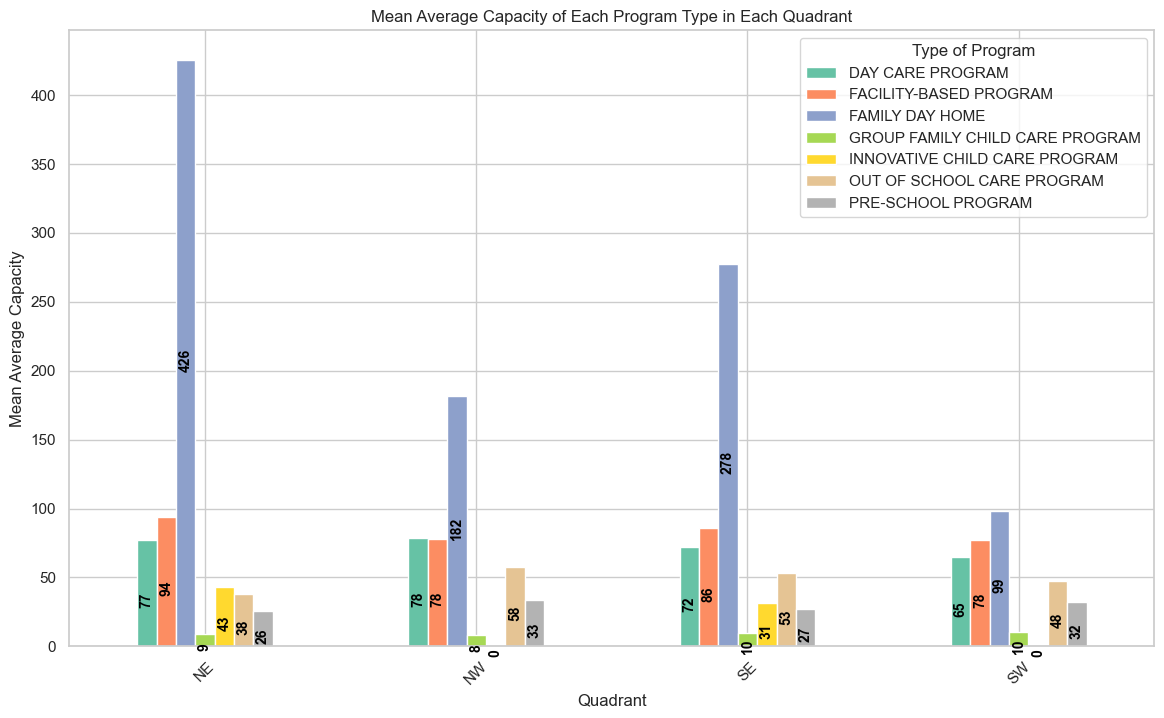

In [54]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.wkt import loads
from shapely.geometry import Point

# Load datasets
inspections_df = pd.read_csv("final_output.csv")
quadrants_df = pd.read_csv("City_Quadrants_20250210.csv")

# Convert MULTIPOLYGON from WKT format to geometry
quadrants_df["geometry"] = quadrants_df["MULTIPOLYGON"].apply(lambda x: loads(x) if isinstance(x, str) else None)
quadrants_gdf = gpd.GeoDataFrame(quadrants_df, geometry="geometry", crs="EPSG:4326")

# Convert inspections to GeoDataFrame
inspections_df = inspections_df.dropna(subset=["latitude", "longitude"])  # Remove rows without coordinates
inspections_gdf = gpd.GeoDataFrame(inspections_df, 
                                   geometry=[Point(xy) for xy in zip(inspections_df.longitude, inspections_df.latitude)],
                                   crs="EPSG:4326")

# Spatial join to map inspections to quadrants
inspections_gdf = gpd.sjoin(inspections_gdf, quadrants_gdf, how="left", predicate="within")

# Calculate mean average capacity of each program type in each quadrant
mean_avg_capacity_per_quadrant = inspections_gdf.groupby(['QUADRANT', 'Type of Program'])['Capacity'].mean().unstack().fillna(0)

# Plot the bar chart for mean average capacity
ax = mean_avg_capacity_per_quadrant.plot(kind='bar', figsize=(14, 8), colormap='Set2')

# Add data labels inside the columns, rotated 90 degrees, rounded off to whole numbers, in black color
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=-5, color='black', weight='bold', fontsize=10, label_type='center', rotation=90)

# Labels and title
plt.xlabel('Quadrant')
plt.ylabel('Mean Average Capacity')
plt.title('Mean Average Capacity of Each Program Type in Each Quadrant')
plt.xticks(rotation=45)
plt.legend(title='Type of Program')

# Show the bar chart
plt.show()


In [60]:
summary_df

,Year,Inspection Count,Non Compliance %
0,2014,965,16.891192
1,2015,1560,15.641026
2,2016,1679,15.187612
3,2017,1811,17.448923
4,2018,1905,21.522310
5,2019,2050,25.463415
6,2020,1423,12.227688
7,2021,1126,16.873890
8,2022,1996,27.154309
9,2023,2069,23.392943
